# Examen Pratique Fil Rouge – Deep Learning
IA2

## 1.1 Telechargement du dataset

In [2]:

import urllib.request, zipfile, os
url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
zip_path = "caltech101.zip"
urllib.request.urlretrieve(url, zip_path)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data_caltech101/")
print("Dataset ready in ./data_caltech101/")


Dataset ready in ./data_caltech101/


## 1.2 Structure du dataset

In [6]:
import os
import tarfile
from pathlib import Path

root = Path("../data_caltech101/caltech-101")

# Chercher le fichier .tar.gz des catégories
tar_path = None
for p in root.rglob("101_ObjectCategories.tar.gz"):
    tar_path = p
    break

if tar_path is None:
    raise RuntimeError("Fichier 101_ObjectCategories.tar.gz introuvable.")

print(f"Fichier trouvé : {tar_path}")

# Dossier cible après extraction
extract_dir = tar_path.parent / "101_ObjectCategories"

# Extraire seulement si pas déjà extrait
if not extract_dir.exists():
    print("Extraction en cours...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=tar_path.parent)
    print("Extraction terminée.\n")
else:
    print("Déjà extrait.\n")

categories_dir = extract_dir

# --- Affichage d'une arborescence simple ---
def print_tree(start_path, max_depth=1):
    start_path = Path(start_path)
    print(start_path.name + "/")
    for item in sorted(start_path.iterdir()):
        prefix = "├── "
        print(prefix + item.name)

print("=== Arborescence du dossier extrait ===")
print_tree(categories_dir, max_depth=1)
print("\n")


Fichier trouvé : ..\data_caltech101\caltech-101\101_ObjectCategories.tar.gz
Déjà extrait.

=== Arborescence du dossier extrait ===
101_ObjectCategories/
├── accordion
├── airplanes
├── anchor
├── ant
├── BACKGROUND_Google
├── barrel
├── bass
├── beaver
├── binocular
├── bonsai
├── brain
├── brontosaurus
├── buddha
├── butterfly
├── camera
├── cannon
├── car_side
├── ceiling_fan
├── cellphone
├── chair
├── chandelier
├── cougar_body
├── cougar_face
├── crab
├── crayfish
├── crocodile
├── crocodile_head
├── cup
├── dalmatian
├── dollar_bill
├── dolphin
├── dragonfly
├── electric_guitar
├── elephant
├── emu
├── euphonium
├── ewer
├── Faces
├── Faces_easy
├── ferry
├── flamingo
├── flamingo_head
├── garfield
├── gerenuk
├── gramophone
├── grand_piano
├── hawksbill
├── headphone
├── hedgehog
├── helicopter
├── ibis
├── inline_skate
├── joshua_tree
├── kangaroo
├── ketch
├── lamp
├── laptop
├── Leopards
├── llama
├── lobster
├── lotus
├── mandolin
├── mayfly
├── menorah
├── metronome
├── min

In [11]:
# --- Compter les classes (sans BACKGROUND_Google) ---
all_classes = [
    d for d in os.listdir(categories_dir)
    if (categories_dir / d).is_dir() and d != "BACKGROUND_Google"
]

nb_classes = len(all_classes)

print("=== Nombre de classes ===")
print(f"Nombre total de classes (hors BACKGROUND_Google) : {nb_classes}\n")


# --- 5 exemples de classes ---
print("=== Exemples ===")
for c in all_classes[:5]:
    print("-", c)

=== Nombre de classes ===
Nombre total de classes (hors BACKGROUND_Google) : 101

=== Exemples ===
- accordion
- airplanes
- anchor
- ant
- barrel


## 1.3 Distribution des classes

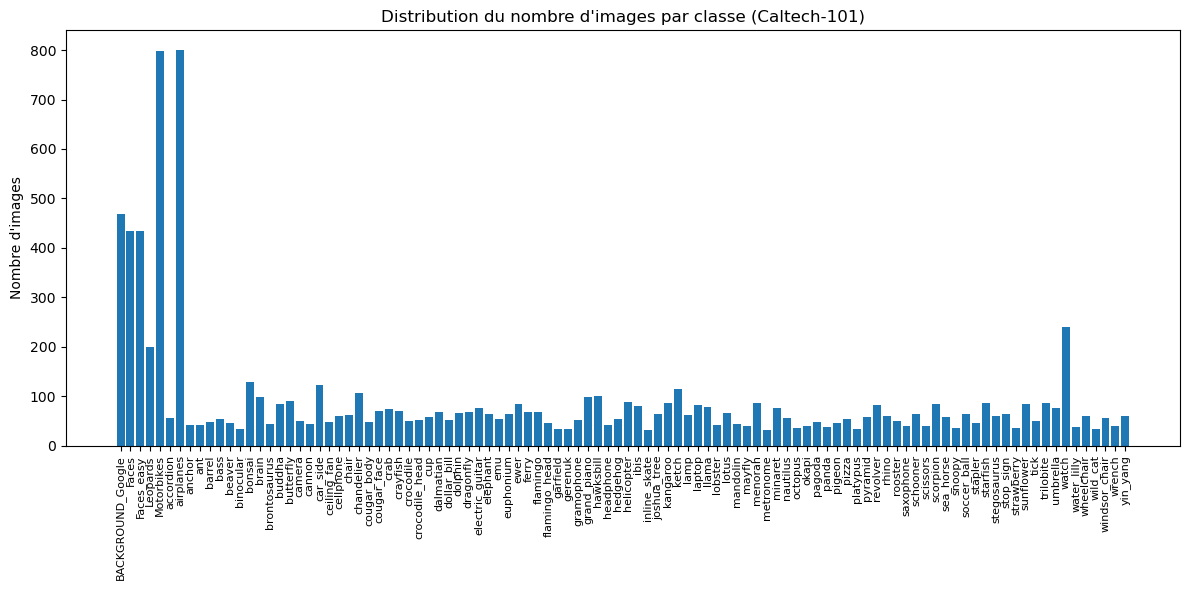

=== Analyse de la distribution ===
Classe la plus sous-représentée : inline_skate (31 images)
Classe la plus sur-représentée : airplanes (800 images)

Ratio max/min = 25.8x
→ Le dataset est clairement déséquilibré.


In [10]:
import os
import matplotlib.pyplot as plt

# On réutilise categories_dir trouvé dans la cellule précédente

# --- Comptage du nombre d'images par classe ---
class_counts = {}

for classe in sorted(os.listdir(categories_dir)):
    class_dir = categories_dir / classe
    if class_dir.is_dir():
        # comptage des images = fichiers dans le dossier
        nb_images = len([f for f in os.listdir(class_dir) if (class_dir / f).is_file()])
        class_counts[classe] = nb_images

# --- Histogramme ---
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Nombre d'images")
plt.title("Distribution du nombre d'images par classe (Caltech-101)")
plt.tight_layout()
plt.show()

# --- Analyse auto : classes extrêmes ---
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print("=== Analyse de la distribution ===")
print(f"Classe la plus sous-représentée : {min_class} ({class_counts[min_class]} images)")
print(f"Classe la plus sur-représentée : {max_class} ({class_counts[max_class]} images)\n")

# Vérifier si le dataset est équilibré (simple ratio)
ratio = class_counts[max_class] / max(1, class_counts[min_class])
print(f"Ratio max/min = {ratio:.1f}x")

if ratio > 3:
    print("→ Le dataset est clairement déséquilibré.")
elif ratio > 1.5:
    print("→ Légèrement déséquilibré.")
else:
    print("→ Plutôt équilibré.")


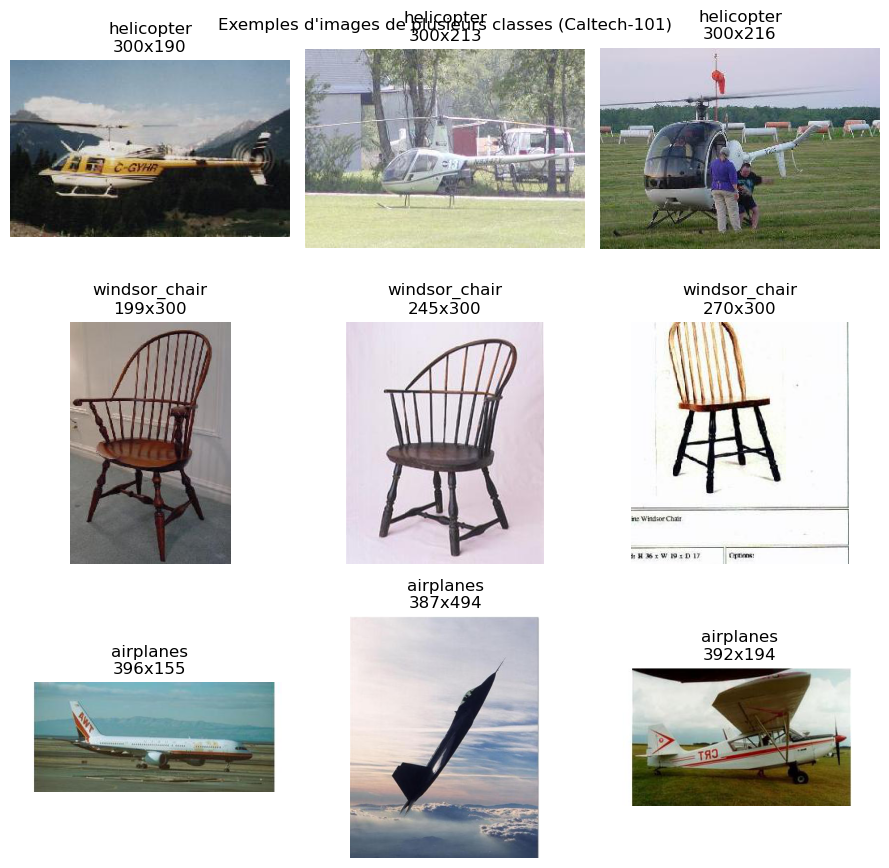

=== Tailles d'images observées parmi les exemples ===
helicopter           | image_0028.jpg            | 300x190
helicopter           | image_0040.jpg            | 300x213
helicopter           | image_0082.jpg            | 300x216
windsor_chair        | image_0031.jpg            | 199x300
windsor_chair        | image_0003.jpg            | 245x300
windsor_chair        | image_0055.jpg            | 270x300
airplanes            | image_0776.jpg            | 396x155
airplanes            | image_0262.jpg            | 387x494
airplanes            | image_0036.jpg            | 392x194

Nombre de résolutions différentes parmi ces exemples : 9
Tailles distinctes : {(300, 190), (396, 155), (245, 300), (199, 300), (270, 300), (392, 194), (387, 494), (300, 213), (300, 216)}


In [31]:
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

# On réutilise categories_dir et all_classes de la partie 1.2
# Si jamais ils n'existent pas (exécution directe de cette cellule), on les recalculera.
if "categories_dir" not in locals():
    from pathlib import Path
    categories_dir = Path("data_caltech101/caltech-101/101_ObjectCategories")

if "all_classes" not in locals():
    all_classes = [
        d for d in os.listdir(categories_dir)
        if (categories_dir / d).is_dir() and d != "BACKGROUND_Google"
    ]

# --- Sélection de quelques classes et images ---
random.seed(25)  # pour avoir quelque chose de reproductible

n_classes = 3          # nombre de classes à afficher
n_images_per_class = 3 # nombre d'images par classe

selected_classes = random.sample(all_classes, n_classes)

images_info = []  # (class_name, image_path, size)

for class_name in selected_classes:
    class_dir = categories_dir / class_name
    # on ne garde que les fichiers image
    img_files = [
        f for f in os.listdir(class_dir)
        if (class_dir / f).is_file() and f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
    ]
    # on limite au nombre voulu
    chosen_files = random.sample(img_files, min(n_images_per_class, len(img_files)))
    for f in chosen_files:
        img_path = class_dir / f
        img = Image.open(img_path)
        images_info.append((class_name, img_path, img.size))
        img.close()

# --- Affichage en grille ---
nb_images = len(images_info)
cols = n_images_per_class
rows = n_classes

plt.figure(figsize=(3 * cols, 3 * rows))

for idx, (class_name, img_path, size) in enumerate(images_info, start=1):
    img = Image.open(img_path)
    plt.subplot(rows, cols, idx)
    plt.imshow(img)
    plt.title(f"{class_name}\n{size[0]}x{size[1]}")
    plt.axis("off")
    img.close()

plt.suptitle("Exemples d'images de plusieurs classes (Caltech-101)", y=0.95)
plt.tight_layout()
plt.show()

# --- Résumé des tailles observées ---
print("=== Tailles d'images observées parmi les exemples ===")
for class_name, img_path, size in images_info:
    print(f"{class_name:20s} | {img_path.name:25s} | {size[0]}x{size[1]}")

unique_sizes = {s for _, _, s in images_info}
print("\nNombre de résolutions différentes parmi ces exemples :", len(unique_sizes))
print("Tailles distinctes :", unique_sizes)
